In [1]:
!pip install bertopic
!pip install sentence-transformers
!pip install openpyxl    
!pip install umap-learn
!pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import re
# For BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
# For custom UMAP and HDBSCAN
import umap
import hdbscan

In [5]:
df = pd.read_excel("la_pairwise_similarity.xlsx")
# Verify columns
print(df.columns)  # Should show ['Text_1', 'Text_2', 'Similarity_Score']

Index(['Text_1', 'Text_2', 'Similarity_Score'], dtype='object')


In [7]:
# Convert each column to a list and remove any NaN values
text_1_list = df["Text_1"].dropna().tolist()
text_2_list = df["Text_2"].dropna().tolist()

# Combine them into a single set to remove duplicates
all_texts_set = set(text_1_list + text_2_list)

# Convert set back to a list
all_texts = list(all_texts_set)

In [9]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

all_texts_cleaned = [clean_text(t) for t in all_texts]

In [11]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [23]:
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')

In [25]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)
topics, probs = topic_model.fit_transform(all_texts_cleaned)

In [26]:
topic_info = topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                             Name  \
0      -1    330                               -1_semst_the_to_is   
1       0    126                              0_semst_the_you_and   
2       1     48                              1_women_men_laws_do   
3       2     25                         2_pray_prayer_prayers_us   
4       3     23                           3_evil_love_jesus_lord   
5       4     22            4_rally4life_repealthe8th_he_bullying   
6       5     22        5_black_blacklivesmatter_parenthood_lives   
7       6     22            6_gaymarriage_marriage_scotus_america   
8       7     21                      7_abortion_wrong_abort_dies   
9       8     18                        8_kill_killing_but_babies   
10      9     17                          9_pro_choice_can_people   
11     10     16           10_feminism_against_dehumanizing_wills   
12     11     16                11_equal_equality_unborn_progress   
13     12     16                  

In [29]:
for topic_id in topic_info["Topic"]:
    if topic_id != -1:  # -1 is the outlier topic
        print(f"Topic {topic_id}:")
        print(topic_model.get_topic(topic_id))
        print("-"*50)

Topic 0:
[('semst', 0.026210235545944677), ('the', 0.016873736709805767), ('you', 0.016197504139072453), ('and', 0.01570224639465725), ('it', 0.015506418959291562), ('to', 0.015260903707561021), ('on', 0.014142009594154605), ('that', 0.013936719510405027), ('is', 0.013335609881776312), ('about', 0.013221263490744211)]
--------------------------------------------------
Topic 1:
[('women', 0.0805849483236304), ('men', 0.039633134797371), ('laws', 0.0373403619155027), ('do', 0.033505425558718965), ('choice', 0.030181179959149537), ('to', 0.02925770426941727), ('decisions', 0.028474705050441643), ('effect', 0.028474705050441643), ('their', 0.028114850676262085), ('anti', 0.0269006484546116)]
--------------------------------------------------
Topic 2:
[('pray', 0.0883449341659143), ('prayer', 0.05348179426860212), ('prayers', 0.04490855434719937), ('us', 0.044680348507083814), ('babies', 0.04189485469853974), ('for', 0.04149054182330053), ('st', 0.04105478317019194), ('in', 0.03703890899998

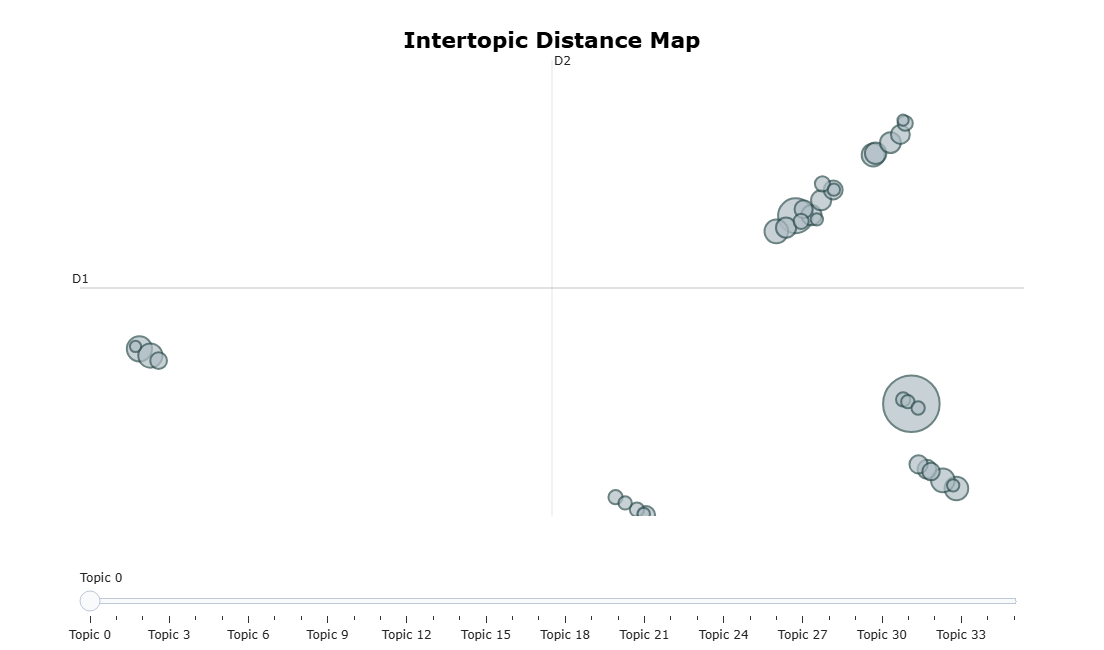

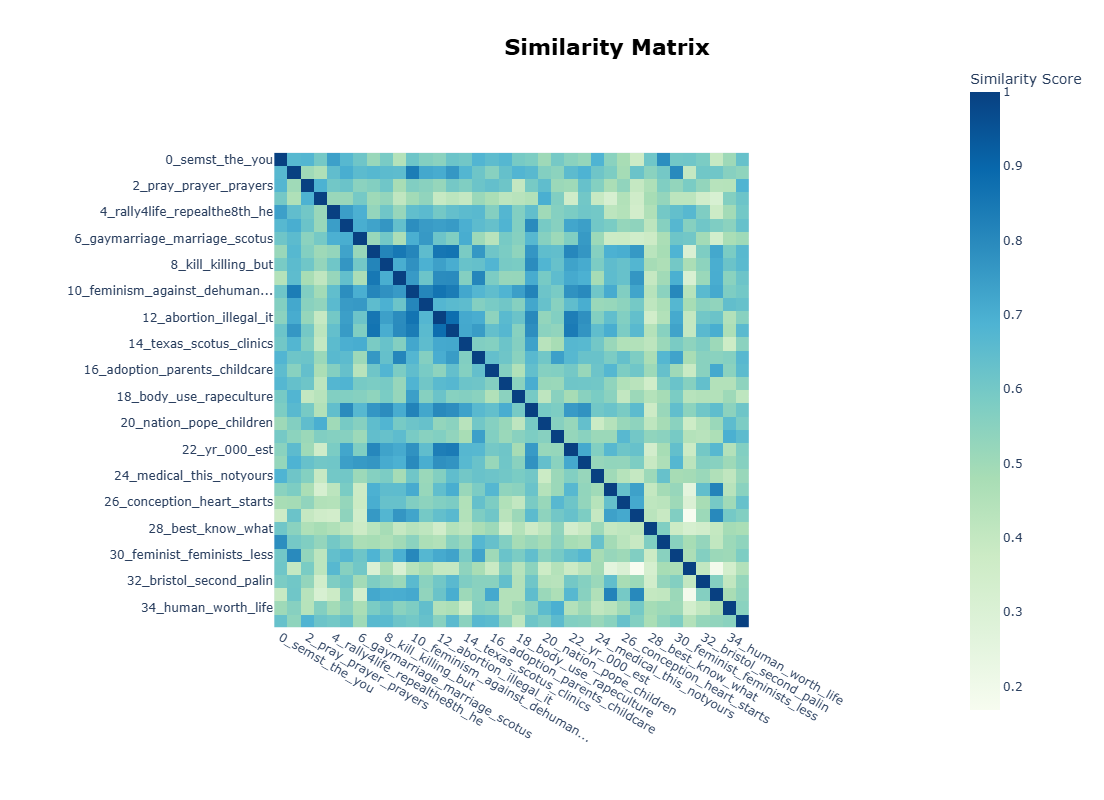

In [33]:
# Check if there are any topics different from -1
if topic_info.shape[0] <= 1 or (topic_info["Topic"].nunique() == 1 and topic_info["Topic"].iloc[0] == -1):
    print("Not enough topics to visualize intertopic distances.")
else:
    intertopic_distance_map = topic_model.visualize_topics()
    intertopic_distance_map.show()

    similarity_heatmap = topic_model.visualize_heatmap()
    similarity_heatmap.show()

In [43]:
results_df = pd.DataFrame({
    "text": all_texts_cleaned,
    "topic": topics
})
results_df.to_excel("la_topics_combined.xlsx", index=False)